<img src="logo.png" alt="University of Illinois" style="width: 200px;"/>

### Error Analysis ###
by: Richard Sowers
* <r-sowers@illinois.edu>
* <https://publish.illinois.edu/r-sowers/>

Copyright 2019 University of Illinois Board of Trustees. All Rights Reserved. Licensed under the MIT license

### Explanation###
This code plots error analysis for Manhattan Traffic Data

imports

In [1]:
import pandas
import numpy
import matplotlib.pylab as plt
%matplotlib inline
import scipy.interpolate
import scipy.optimize

constants

In [2]:
colorsequence=['b', 'g', 'r', 'c', 'm', 'y', 'k']

In [3]:
fname="LevelCurveData2"

read data

In [4]:
data_raw=pandas.read_csv(fname+".csv",na_values=['nan',' nan'])
print(data_raw)

    rank  beta  no_iterations  pre_error  post_error  pre_sparsity  \
0     40     0            263  26.638031   41.724601      0.673253   
1     40  1000            174  26.958008   41.843305      0.693565   
2     40  2000            176  26.952959   41.781512      0.715966   
3     40  3000            177  26.990673   41.414115      0.730479   
4     40  4000            179  27.039437   41.120108      0.741846   
5     40  5000            180  27.107603   40.823740      0.750373   
6     40  6000            179  27.200291   40.558133      0.756349   
7     40  7000            177  27.313106   40.605093      0.760755   
8     40  8000            171  27.471069   40.606574      0.762338   
9     40  9000            182  27.645194         NaN      0.773470   
10    50     0            270  25.361975   41.153543      0.694137   
11    50  1000            187  25.667488   41.022584      0.724678   
12    50  2000            200  25.591666   40.397311      0.755850   
13    50  3000      

In [5]:
data=data_raw.copy()
data=data.set_index(keys=["rank","beta"])
data=data[["pre_error","pre_sparsity"]]
data=data.rename(mapper={"pre_error":"error","pre_sparsity":"sparsity"},axis="columns")
print(data.head())
print(data.columns)

               error  sparsity
rank beta                     
40   0     26.638031  0.673253
     1000  26.958008  0.693565
     2000  26.952959  0.715966
     3000  26.990673  0.730479
     4000  27.039437  0.741846
Index(['error', 'sparsity'], dtype='object')


In [6]:
class processor:
    def __init__(self,df):
        self.rank_vals=pandas.unique(df.index.get_level_values("rank"))
        self.df=df.dropna(axis="index")
        
    def by_penalty(self,rank):
        temp=self.df.groupby(by="rank").get_group(rank)
        return temp.reset_index(level="rank",drop=True)
    
    def sparsity_by_penalty(self,rank):
        temp=self.by_penalty(rank)["sparsity"]
        return temp
    
    def error_by_sparsity(self,rank):
        temp=self.by_penalty(rank)
        temp=temp.set_index(keys="sparsity",drop=True)["error"]
        temp.sort_index(axis="index",inplace=True)
        return temp
    
p=processor(data)

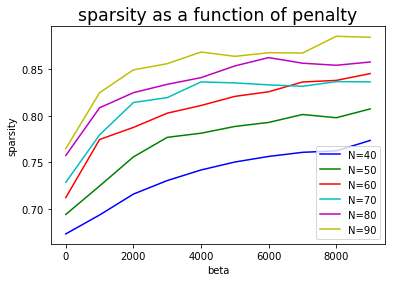

In [7]:
plt.figure()
for n,rank in enumerate(p.rank_vals):
    df=p.sparsity_by_penalty(rank)
    plt.plot(df.index,df.values,label="N={:}".format(rank),color=colorsequence[n])
plt.legend()
plt.xlabel("beta")
plt.ylabel("sparsity")
plt.title("sparsity as a function of penalty",fontsize="xx-large")
plt.show()
plt.close()

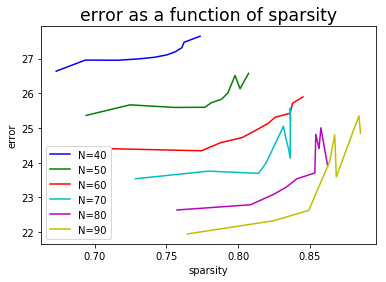

In [8]:
plt.figure()
for n,rank in enumerate(p.rank_vals):
    df=p.error_by_sparsity(rank)
    plt.plot(df.index,df.values,label="N={:}".format(rank),color=colorsequence[n])
plt.legend()
plt.xlabel("sparsity")
plt.ylabel("error")
plt.title("error as a function of sparsity",fontsize="xx-large")
plt.show()
plt.close()

In [11]:
class monotone_invert:
    def __init__(self,df,sign="increasing"):
        self.df=df
        if len(self.df)<2:
            return None
        self.N=len(self.df)
        self.tvals=numpy.array(self.df.index)
        self.yvals=numpy.array(self.df.to_numpy())
        self.L=numpy.tril(numpy.ones(shape=(self.N,self.N)),k=0)
        self.ctr=1
        x0=[numpy.mean(self.yvals)/self.N]*self.N
        
        def objective(d):
            error=self.yvals-self.L.dot(d)
            return 0.5*error.dot(error)
        
        def jacobian(self,d): #not used
            error=self.yvals-self.L.dot(d)
            return self.L.T.dot(error)
        
        def hessian(self,d): # not used
            return self.L.T*dot(self.L)
        
        print(self.N)
        pm=1
        if (sign=="decreasing"):
            pm=-1
        constraints={"type":"ineq","fun":lambda x:pm*x}
        res=scipy.optimize.minimize(objective,x0=x0,method="COBYLA",constraints=constraints)
        print(res)
        d_best=res.x
        self.y_approx_vals=self.L.dot(d_best)
        print("y_approx",self.y_approx_vals)
        
        self.linapprox=scipy.interpolate.interp1d(self.tvals,self.y_approx_vals,copy=True,bounds_error=True)
        
    def inc_approx(self,t):
        if not (min(self.tvals)<=t<=max(self.tvals)):
            return numpy.nan
        return self.linapprox(t).item()

        
        tval=scipy.optimize.brentq(lambda x:self.linapprox(x)-yval,min(self.tvals),max(self.tvals))
        return tval
    
    
print(p.rank_vals)
t=p.error_by_sparsity(40)
print(t)
mi=monotone_invert(t)

[40 50 60 70 80 90]
sparsity
0.673253    26.638031
0.693565    26.958008
0.715966    26.952959
0.730479    26.990673
0.741846    27.039437
0.750373    27.107603
0.756349    27.200291
0.760755    27.313106
0.762338    27.471069
0.773470    27.645194
Name: error, dtype: float64
10
     fun: 2.9745238422591102e-05
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 1000
  status: 2
 success: False
       x: array([2.66327772e+01, 3.24910269e-01, 5.42101086e-20, 3.26247686e-02,
       4.90956517e-02, 6.72107073e-02, 9.62764735e-02, 1.09308401e-01,
       1.58669612e-01, 1.75151508e-01])
y_approx [26.63277722 26.95768749 26.95768749 26.99031226 27.03940791 27.10661862
 27.20289509 27.3122035  27.47087311 27.64602462]


In [12]:
fdict={rank:monotone_invert(p.error_by_sparsity(rank)) for rank in p.rank_vals}

10
     fun: 2.9745238422591102e-05
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 1000
  status: 2
 success: False
       x: array([2.66327772e+01, 3.24910269e-01, 5.42101086e-20, 3.26247686e-02,
       4.90956517e-02, 6.72107073e-02, 9.62764735e-02, 1.09308401e-01,
       1.58669612e-01, 1.75151508e-01])
y_approx [26.63277722 26.95768749 26.95768749 26.99031226 27.03940791 27.10661862
 27.20289509 27.3122035  27.47087311 27.64602462]
10
     fun: 0.03819784998681285
   maxcv: 5.998884258004354e-20
 message: 'Optimization terminated successfully.'
    nfev: 996
  status: 1
 success: True
       x: array([ 2.53602855e+01,  2.59058152e-01, -5.99888426e-20, -4.39835486e-22,
        1.06230800e-01,  1.07268420e-01,  1.76306649e-01,  3.13410655e-01,
        4.85722573e-21,  2.54008791e-01])
y_approx [25.36028545 25.6193436  25.6193436  25.6193436  25.7255744  25.83284282
 26.00914947 26.32256013 26.32256013 26.57656892]
10
     fun: 0.00105759

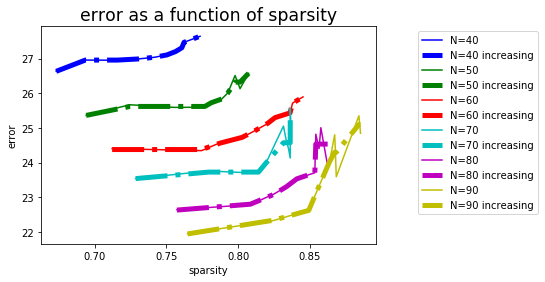

In [13]:
plt.figure()
for n,rank in enumerate(p.rank_vals):
    df=p.error_by_sparsity(rank)
    plt.plot(df.index,df.values,label="N={:}".format(rank),color=colorsequence[n])
    temp=fdict[rank]
    try:
        plt.plot(temp.tvals,temp.y_approx_vals,label="N={:} increasing".format(rank),linewidth=5,linestyle="-.",color=colorsequence[n])
    except Exception:
        pass
plt.legend(bbox_to_anchor=(1.5, 1))
plt.xlabel("sparsity")
plt.ylabel("error")
plt.title("error as a function of sparsity",fontsize="xx-large")
plt.show()
plt.close()

In [14]:
sparsityvals=numpy.linspace(start=0.70,stop=0.93,num=10)
print(sparsityvals)

[0.7        0.72555556 0.75111111 0.77666667 0.80222222 0.82777778
 0.85333333 0.87888889 0.90444444 0.93      ]


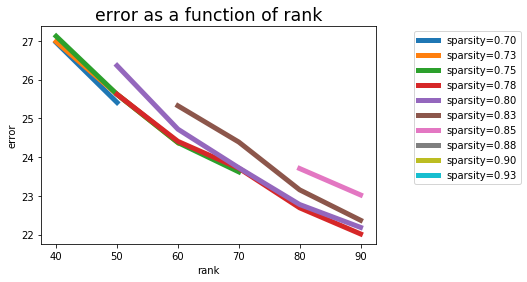

In [15]:
    plt.figure()
    for sparsity in sparsityvals:
        errvals=[fdict[rank].inc_approx(sparsity)  for rank in p.rank_vals]
        plt.plot(p.rank_vals,errvals,linewidth=5,label="sparsity={:.2f}".format(sparsity))

    plt.legend(bbox_to_anchor=(1.1, 1))
    plt.xlabel("rank")
    plt.ylabel("error")
    plt.title("error as a function of rank",fontsize="xx-large")
    plt.show()
    plt.close()
    